# Сборный проект

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса. <br>
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.<br>
У вас будет несколько задач:
- Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
- Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

In [1]:
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

!pip install phik
import phik
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
!pip install shap
import shap
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import (
    accuracy_score, mean_absolute_error, mean_squared_error,
    r2_score, confusion_matrix, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, make_scorer
)

from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

from sklearn.metrics import fbeta_score
from sklearn.dummy import DummyRegressor, DummyClassifier

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV

!pip install optuna
!pip install optuna-integration
from optuna.integration import OptunaSearchCV
from optuna import visualization

from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, OneHotEncoder,
    OrdinalEncoder, LabelEncoder, PolynomialFeatures
)


In [2]:
RANDOM_STATE = 55

## Предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [3]:
try:
    train_data = pd.read_csv('train_job_satisfaction_rate.csv')
except:
    train_data = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
try:
    test_data_features = pd.read_csv('test_features.csv')
except:
    test_data_features = pd.read_csv('/datasets/test_features.csv')
try:
    test_data_target = pd.read_csv('test_target_job_satisfaction_rate.csv')
except:
    test_data_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

### Предобработка данных

In [4]:
display(train_data.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [5]:
display(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

In [6]:
display(test_data_features.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [7]:
display(test_data_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

In [8]:
display(test_data_target.head())

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [9]:
display(test_data_target.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

**Поищем пропуски в датасетах.**

In [10]:
train_data.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [11]:
# Посмотрим на записи с пропусками.
train_data[train_data['dept'].isna() | train_data['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [12]:
# Посмотрим, какую долю занимают строки с пропусками в общем датасете.
train_data[train_data['dept'].isna()].shape[0] / train_data.shape[0]

0.0015

In [13]:
train_data[train_data['level'].isna()].shape[0] / train_data.shape[0]

0.001

Пропусков слишком мало, эти строки можно будет отбросить.

In [14]:
test_data_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [15]:
test_data_features[test_data_features['dept'].isna() | test_data_features['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [16]:
# Посмотрим, какую долю занимают строки с пропусками в общем датасете.
test_data_features[test_data_features['dept'].isna()].shape[0] / test_data_features.shape[0]

0.001

In [17]:
test_data_features[test_data_features['level'].isna()].shape[0] / test_data_features.shape[0]

0.0005

Пропусков слишком мало, эти строки можно будет отбросить.

In [18]:
test_data_target.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

**Поищем явные дубликаты в датасетах.**

По данным всех столбцов, кроме 'id' данные могут повторяться и это может не считаться дубликатом, поэтому логичнее искать дубликаты по столбцу 'id'.

In [19]:
train_data['id'].duplicated().sum()

0

In [20]:
test_data_features['id'].duplicated().sum()

0

In [21]:
test_data_target['id'].duplicated().sum()

0

**Поищем неявные дубликаты в датасетах.**

In [22]:
train_data.columns.unique()

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')

In [23]:
# Поищем повторяющиеся значения в столбцах.
for col in train_data.columns:
    if col != 'id' and train_data[col].dtype == 'object' :
        print(train_data[col].unique())
        print()

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]

['junior' 'middle' 'sinior' nan]

['medium' 'high' 'low']

['no' 'yes']

['no' 'yes']



In [24]:
train_data['level'] = train_data['level'].replace({'sinior': 'senior'})
test_data_features['level'] = test_data_features['level'].replace({'sinior': 'senior'})

In [25]:
train_data['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

**Вывод**

В датасетах пропуски есть, но их слишком мало, эти данные можно будет отбросить. 
В будущем воспользуемся пайплайном, со стратегией заполнения - most-frequent.

### Исследовательский анализ данных

In [26]:
# количественные признаки
num_cols = []
# категориальные признаки
cat_cols = []
for col in train_data.columns:
    if col != 'id':
        if train_data[col].dtype == 'object' :
            cat_cols.append(col)
        else:
            num_cols.append(col)

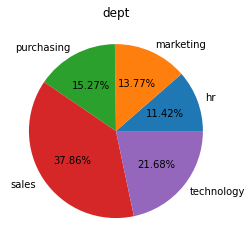

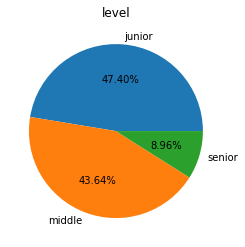

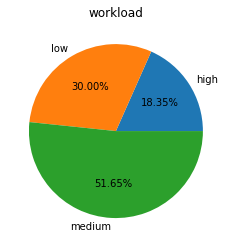

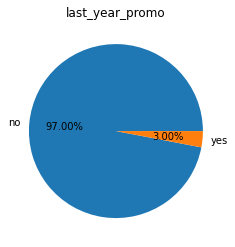

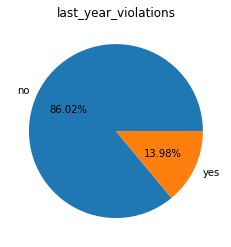

In [27]:
for col in cat_cols:
    data_tmp = train_data.pivot_table(index = col, values = 'id', aggfunc = 'count')
    plt.pie(data_tmp['id'], labels = data_tmp.index, autopct = '%1.2f%%')
    plt.title(col)
    plt.show()

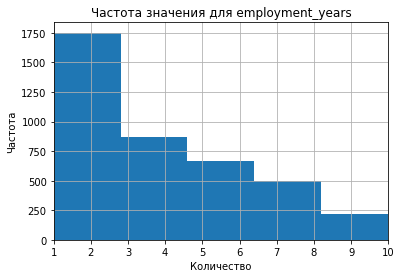

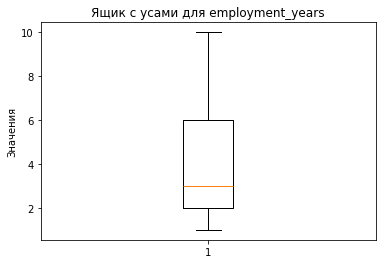



Статистика


count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

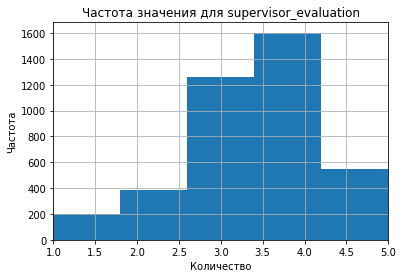

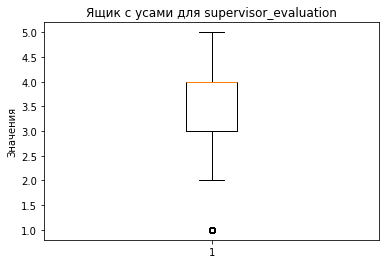



Статистика


count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

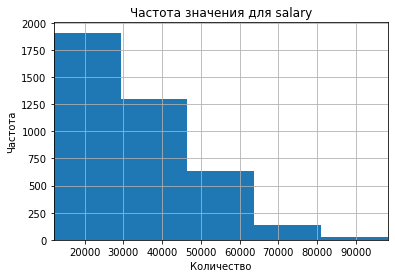

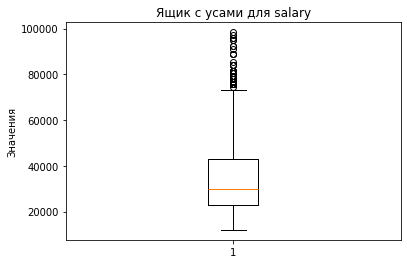



Статистика


count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

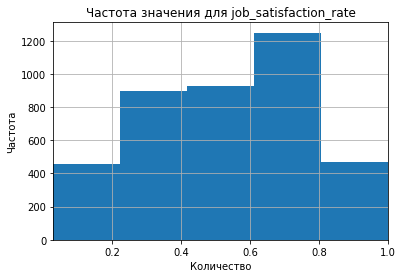

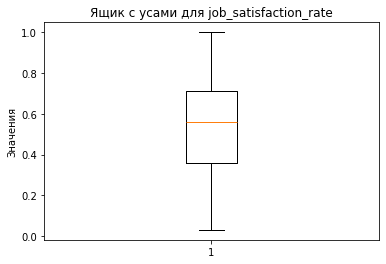



Статистика


count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

In [28]:
for col in num_cols:
    train_data[col].hist(bins = 5)
    plt.xlim(train_data[col].min(), train_data[col].max())
    plt.title(f"Частота значения для {col}")
    plt.ylabel('Частота')
    plt.xlabel('Количество')
    plt.show()
    print("\n")
    plt.boxplot(train_data[col])
    plt.title(f"Ящик с усами для {col}")
    plt.ylabel('Значения')
    plt.show()
    print("\n")
    print("Статистика")
    display(train_data[col].describe())

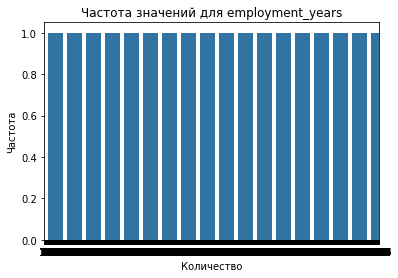

In [29]:
plt.title(f"Частота значений для employment_years")
plt.ylabel('Частота')
plt.xlabel('Количество')
sns.countplot(train_data['employment_years']);

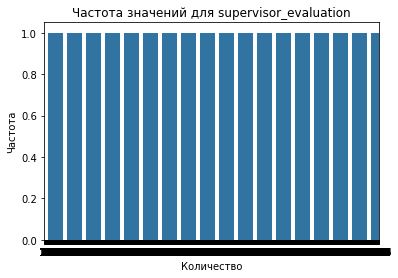

In [30]:
plt.title(f"Частота значений для supervisor_evaluation")
plt.ylabel('Частота')
plt.xlabel('Количество')
sns.countplot(train_data['supervisor_evaluation']);

In [31]:
# Анализ test-выборки
# количественные признаки
num_cols = []
# категориальные признаки
cat_cols = []
for col in test_data_features.columns:
    if col != 'id':
        if test_data_features[col].dtype == 'object' :
            cat_cols.append(col)
        else:
            num_cols.append(col)

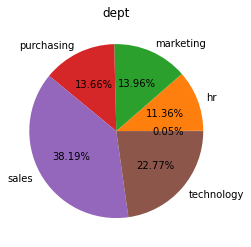

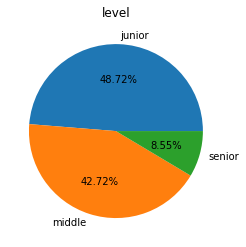

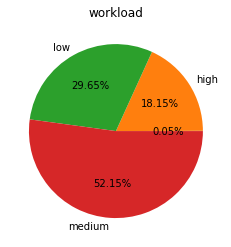

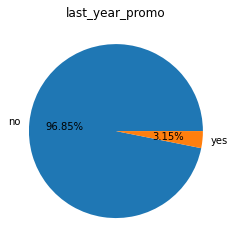

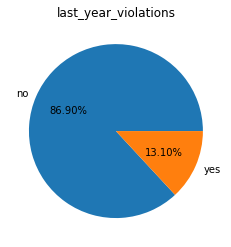

In [32]:
for col in cat_cols:
    data_tmp = test_data_features.pivot_table(index = col, values = 'id', aggfunc = 'count')
    plt.pie(data_tmp['id'], labels = data_tmp.index, autopct = '%1.2f%%')
    plt.title(col)
    plt.show()

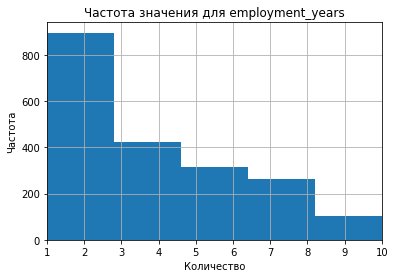

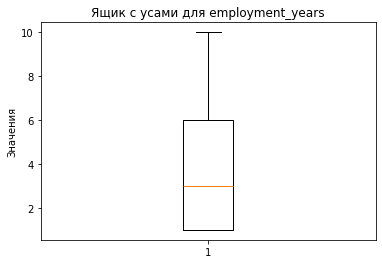



Статистика


count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

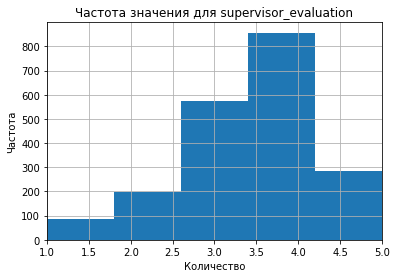

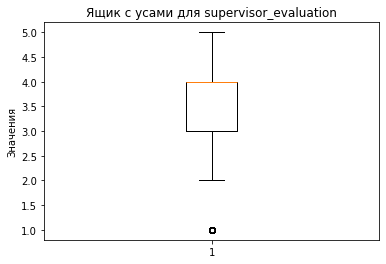



Статистика


count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

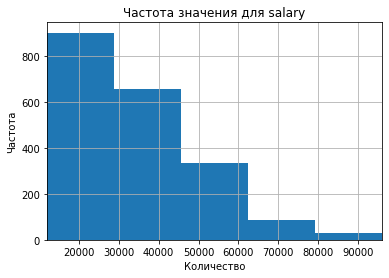

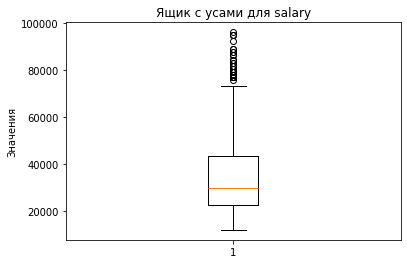



Статистика


count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

In [33]:
for col in num_cols:
    test_data_features[col].hist(bins = 5)
    plt.xlim(test_data_features[col].min(), test_data_features[col].max())
    plt.title(f"Частота значения для {col}")
    plt.ylabel('Частота')
    plt.xlabel('Количество')
    plt.show()
    print("\n")
    plt.boxplot(test_data_features[col])
    plt.title(f"Ящик с усами для {col}")
    plt.ylabel('Значения')
    plt.show()
    print("\n")
    print("Статистика")
    display(test_data_features[col].describe())

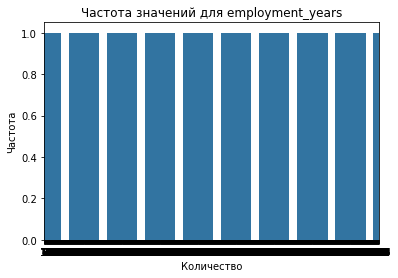

In [34]:
plt.title(f"Частота значений для employment_years")
plt.ylabel('Частота')
plt.xlabel('Количество')
sns.countplot(test_data_features['employment_years']);

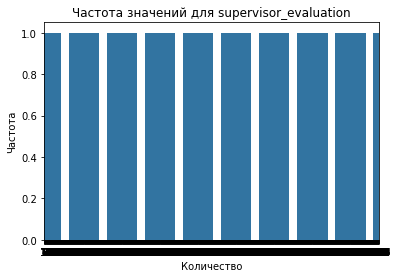

In [35]:
plt.title(f"Частота значений для supervisor_evaluation")
plt.ylabel('Частота')
plt.xlabel('Количество')
sns.countplot(test_data_features['supervisor_evaluation']);

**Вывод**
- Тестовая и тренировочная выборки имеют одинаковое распределение.
- Большая часть работников занимаются продажами, меньшая часть - HR.
- Больше всего работников уровня Junior и меньше всего специалистов уровня Senior.
- По загруженности видно, что примерно у 52% сотрудников средняя занятость, низкая загруженность у 30% сотрудников, у 18.35% процентов - высокая.
- Повышение получили всего 3 процента сотрудников в течение года.
- Около 14% сотрудников нарушили трудовой договор.
- Много сотрудников работают около двух лет, более опытных сотрудников меньше и меньше с увеличением значения стажа.
Минимальный стаж сотрудников - 1 год, максимальный - 10 лет.
- Множество сотрудников стараются, потому есть хорошие оценки, но  присутсвуют и недобросовестные сотрудники с оценкой равной 1.
- График распределения зарплаты напоминает распределение Пуасонна, вполне ожидаемо, что хвост будет протягиваться в сторону высоких зарплат.
- Минимальная зарплата - 12000, медиана - 30000, максимальная - 98400.
- Гистограмма оценки удовлетворенности сотрудника напоминает нормальное распределение, но с небольшим смещением вправо, что весьма хорошо, это означает, что медиана находится выше чем половина оценки. 

**Корреляционный анализ**

In [36]:
test_data = test_data_features.merge(test_data_target, on = 'id')
test_data.head()

interval_cols = ['salary', 'job_satisfaction_rate']

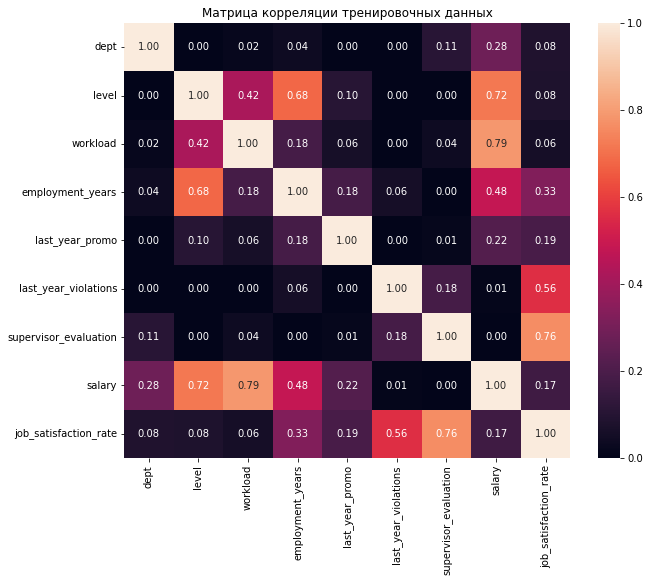

In [37]:
fig, axes = plt.subplots(figsize=(10, 8))
sns.heatmap(train_data.drop(['id'], axis=1).phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f', ax=axes)

plt.title('Матрица корреляции тренировочных данных')
plt.show()

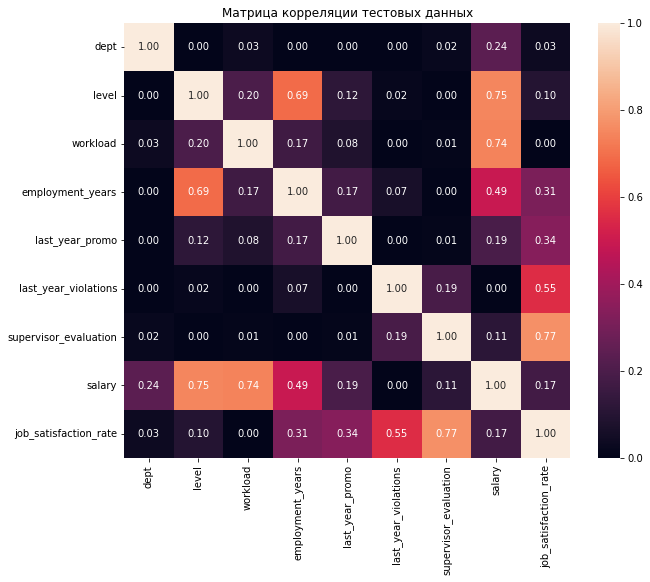

In [38]:
fig, axes = plt.subplots(figsize=(10, 8))
sns.heatmap(test_data.drop(['id'], axis=1).phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f', ax=axes)

plt.title('Матрица корреляции тестовых данных')
plt.show()


Наибольшие коэффициенты корреляции с таргет признаком имеют supervisor_evaluation и last_year_violations. 
Это логично, так как наличие нарушений и оценка качества руководителя могут так сильно повлиять на таргет.

### Подготовка данных

В данных содержатся пропуски, поэтому необходимо написать пайплайн, устраняющий их.

In [39]:
for col in cat_cols:
    print(col)
    print(train_data[col].unique())

dept
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level
['junior' 'middle' 'senior' nan]
workload
['medium' 'high' 'low']
last_year_promo
['no' 'yes']
last_year_violations
['no' 'yes']


Столбец 'level' закодируем при помощи OrdinalEncoder, остальные столбцы закодируем при помощи OneHotEncoder.

Так как пропусков немного, стратегия заполнения - most_frequent.

In [40]:
ohe_cols = ['dept', 'workload', 'last_year_promo', 'last_year_violations']
ord_cols = ['level']
num_cols = ['employment_years', 'supervisor_evaluation', 'salary']
ohe_pipe = Pipeline([
        (
            'simple_imputer_ohe', 
            SimpleImputer(
                missing_values = np.nan, 
                strategy = 'most_frequent'
            )
        ),
        (
            'ohe', 
            OneHotEncoder(
                drop = 'first', 
                handle_unknown = 'ignore'
            )
        )
    ]
)

ord_pipe = Pipeline([
        (
            'simple_imputer_ord_before', 
            SimpleImputer(
                missing_values = np.nan, 
                strategy = 'most_frequent'
            )
        ),
        (
            'ord',
            OrdinalEncoder(
                categories = [
                    ['junior', 'middle', 'senior']
                ],
                handle_unknown = 'use_encoded_value',
                unknown_value = np.nan
            )
        ),
        (
            'simple_imputer_ord_after', 
            SimpleImputer(
                missing_values = np.nan, 
                strategy = 'most_frequent'
            )
        )
    ]
)

In [41]:
data_preprocessing = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder = 'passthrough'
)

### Обучение моделей

In [42]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessing),
        ('models', LinearRegression())
    ]
)

In [43]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__min_samples_split': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVR()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [LinearRegression()],  
        'models__kernel' : ['linear', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [Lasso(random_state = RANDOM_STATE), Ridge(random_state = RANDOM_STATE)],  
        'models__alpha': [0, 0.2, 0.25, 0.3, 0.5, 0.75, 0.8, 0.9, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]


In [44]:
train_data = train_data.drop(['id'], axis=1)

In [45]:
# Удалим дубликаты
train_data = train_data.drop_duplicates(ignore_index=True)

In [46]:
y_train = train_data['job_satisfaction_rate']
X_train = train_data.drop(['job_satisfaction_rate'], axis=1)

In [47]:
def smape_function(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denumerator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(numerator / denumerator) * 100

smape = make_scorer(smape_function, greater_is_better = False)

In [48]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv = 5,
    scoring = smape,
    random_state = RANDOM_STATE,
    n_jobs = -1
)
X_train

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,sales,junior,medium,2,no,no,1,24000
1,hr,junior,high,2,no,no,5,38400
2,sales,junior,low,1,no,no,2,12000
3,technology,junior,low,4,no,no,2,18000
4,hr,junior,medium,1,no,no,3,22800
...,...,...,...,...,...,...,...,...
3750,hr,senior,high,6,no,no,4,80400
3751,sales,junior,medium,2,no,no,3,20400
3752,sales,middle,low,7,no,no,5,24000
3753,sales,junior,medium,2,no,no,3,24000


In [49]:
y_train

0       0.58
1       0.76
2       0.11
3       0.37
4       0.20
        ... 
3750    0.88
3751    0.27
3752    0.76
3753    0.48
3754    0.18
Name: job_satisfaction_rate, Length: 3755, dtype: float64

In [50]:
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', abs(randomized_search.best_score_))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simple_imputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'workload',
                                                   'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[

In [51]:
best_model = randomized_search.best_estimator_['models']
best_model_preprocessor = randomized_search.best_estimator_['preprocessor']

In [52]:
test_data_encoded = best_model_preprocessor.transform(test_data.drop(['id', 'job_satisfaction_rate'], axis = 1))
y_predict = best_model.predict(test_data_encoded)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [53]:
smape_function(test_data['job_satisfaction_rate'], y_predict)

13.895528971169972

**Вывод**

Удалось обучить модель SVR, показавшую результат ~13.8 по метрике smape, что удовлетворяет нашим требованиям (<=15).

In [54]:
# создание и обучение модели DummyRegressor 
dummy_model = DummyRegressor()
dummy_model.fit(X_train, y_train)

# предсказание на тестовых данных
test_data_encoded = dummy_model.predict(test_data.drop(['id', 'job_satisfaction_rate'], axis = 1))
y_predict_1 = dummy_model.predict(test_data_encoded)
# считаем smape
smape_function(test_data['job_satisfaction_rate'], y_predict_1)

38.26225790202237

**Результат модели SVR лучше, чем DummyRegressor. Значит найденная модель работает лучше.**

## Предсказание увольнения сотрудника из компании

### Загрузка данных

In [55]:
try:
    train_data_quit = pd.read_csv('train_quit.csv')
except:
    train_data_quit = pd.read_csv('/datasets/train_quit.csv')
try:
    test_data_target_quit = pd.read_csv('test_target_quit.csv')
except:
    test_data_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

### Предобработка данных

In [56]:
test_data_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [57]:
train_data_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [58]:
test_data_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Проверим наличие пропусков.

In [59]:
train_data_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [60]:
test_data_target_quit.isna().sum()

id      0
quit    0
dtype: int64

Пропусков нет.

Проверим данные на явные дубликаты.

In [61]:
train_data_quit['id'].duplicated().sum()

0

In [62]:
test_data_target_quit['id'].duplicated().sum()

0

Проверим данные на неявные дубликаты.

In [63]:
for col in train_data_quit.columns:
    if col == 'id':
        continue
    print(col)
    print(train_data_quit[col].unique())

dept
['sales' 'purchasing' 'marketing' 'technology' 'hr']
level
['middle' 'junior' 'sinior']
workload
['high' 'medium' 'low']
employment_years
[ 2  5  1  8  4  7  3  9  6 10]
last_year_promo
['no' 'yes']
last_year_violations
['no' 'yes']
supervisor_evaluation
[4 1 3 5 2]
salary
[54000 27600 37200 24000 25200 18000 44400 19200 45600 57600 33600 16800
 22800 26400 82800 32400 39600 30000 46800 12000 15600 58800 60000 66000
 21600 38400 62400 40800 56400 34800 28800 52800 20400 36000 61200 48000
 43200 73200 31200 78000 64800 72000 94800 96000 63600 79200 55200 42000
 49200 50400 14400 13200 51600 67200 88800 68400 69600 70800 84000 81600
 87600 75600 91200 76800 74400 80400 85200 86400 92400]
quit
['no' 'yes']


In [64]:
train_data_quit['level'] = train_data_quit['level'].replace({'sinior': 'senior'})

In [65]:
train_data_quit['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

**Вывод**

Значение "sinior" в столбце level заменено на "senior". Дубликатов и пропусков не обнаружено.

### Исследовательский анализ данных

In [66]:
# количественные признаки
num_cols = []
# категориальные признаки
cat_cols = []
for col in train_data_quit.columns:
    if col != 'id':
        if train_data_quit[col].dtype == 'object' :
            cat_cols.append(col)
        else:
            num_cols.append(col)

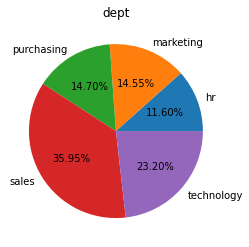

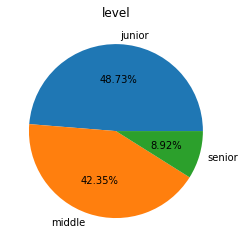

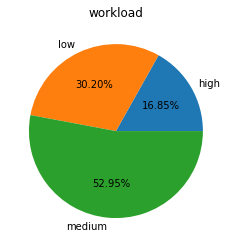

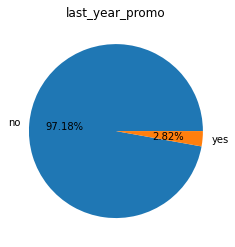

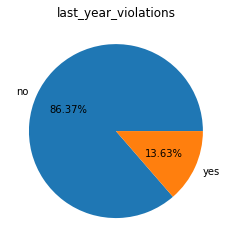

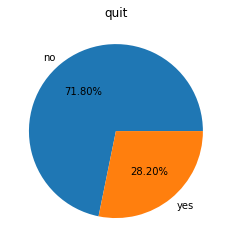

In [67]:
for col in cat_cols:
    data_tmp = train_data_quit.pivot_table(index = col, values = 'id', aggfunc = 'count')
    plt.pie(data_tmp['id'], labels = data_tmp.index, autopct = '%1.2f%%')
    plt.title(col)
    plt.show()

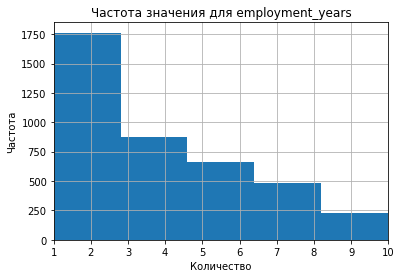

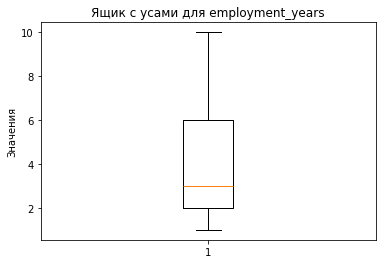



Статистика


count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

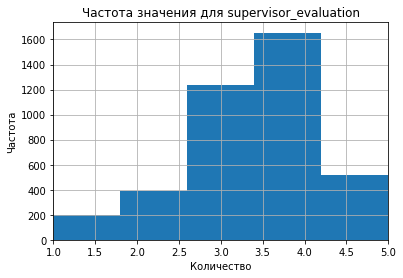

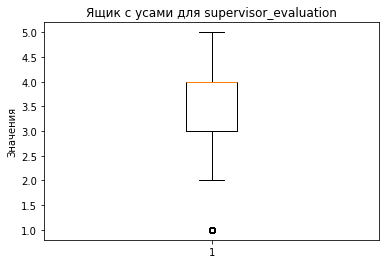



Статистика


count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

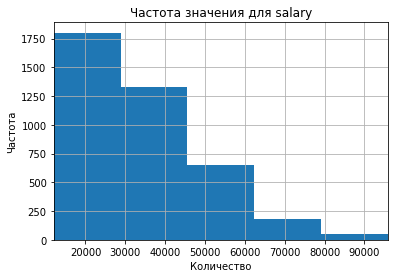

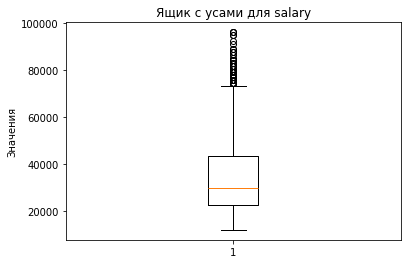



Статистика


count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

In [68]:
for col in num_cols:
    train_data_quit[col].hist(bins = 5)
    plt.xlim(train_data_quit[col].min(), train_data_quit[col].max())
    plt.title(f"Частота значения для {col}")
    plt.ylabel('Частота')
    plt.xlabel('Количество')
    plt.show()
    print("\n")
    plt.boxplot(train_data_quit[col])
    plt.title(f"Ящик с усами для {col}")
    plt.ylabel('Значения')
    plt.show()
    print("\n")
    print("Статистика")
    display(train_data_quit[col].describe())

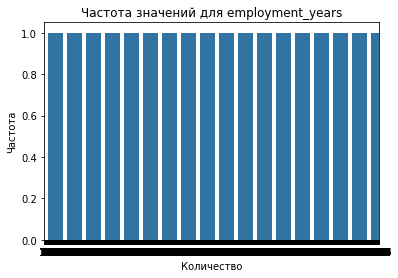

In [69]:
plt.title(f"Частота значений для employment_years")
plt.ylabel('Частота')
plt.xlabel('Количество')
sns.countplot(train_data_quit['employment_years']);

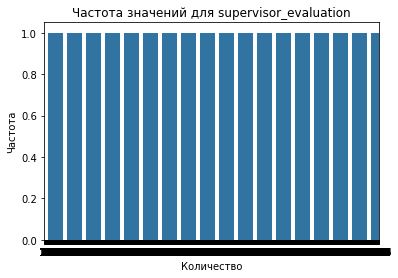

In [70]:
plt.title(f"Частота значений для supervisor_evaluation")
plt.ylabel('Частота')
plt.xlabel('Количество')
sns.countplot(train_data_quit['supervisor_evaluation']);

In [71]:
# количественные признаки
num_cols = []
# категориальные признаки
cat_cols = []
for col in test_data_features.columns:
    if col != 'id':
        if test_data_features[col].dtype == 'object' :
            cat_cols.append(col)
        else:
            num_cols.append(col)

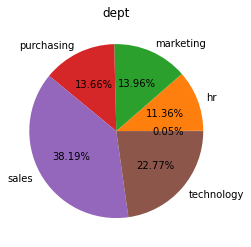

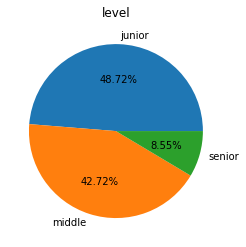

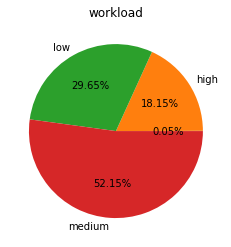

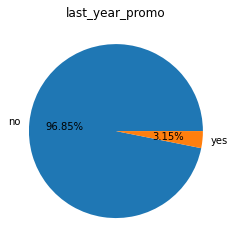

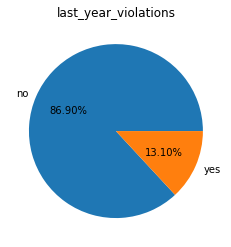

In [72]:
for col in cat_cols:
    data_tmp = test_data_features.pivot_table(index = col, values = 'id', aggfunc = 'count')
    plt.pie(data_tmp['id'], labels = data_tmp.index, autopct = '%1.2f%%')
    plt.title(col)
    plt.show()

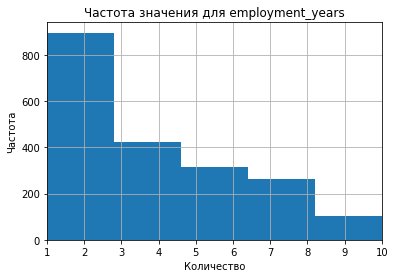

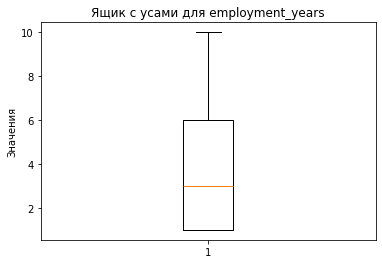



Статистика


count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

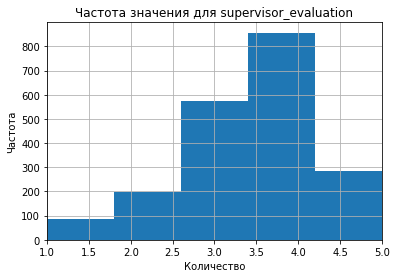

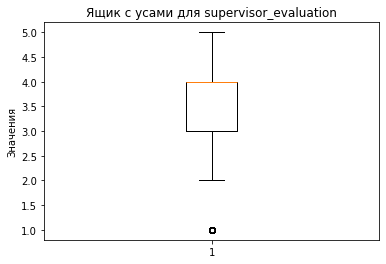



Статистика


count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

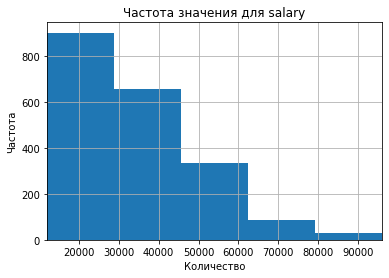

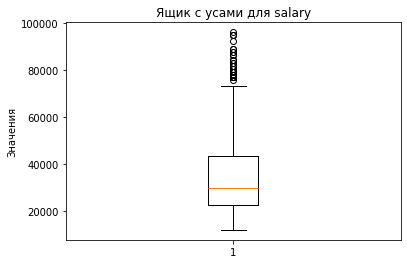



Статистика


count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

In [73]:
for col in num_cols:
    test_data_features[col].hist(bins = 5)
    plt.xlim(test_data_features[col].min(), test_data_features[col].max())
    plt.title(f"Частота значения для {col}")
    plt.ylabel('Частота')
    plt.xlabel('Количество')
    plt.show()
    print("\n")
    plt.boxplot(test_data_features[col])
    plt.title(f"Ящик с усами для {col}")
    plt.ylabel('Значения')
    plt.show()
    print("\n")
    print("Статистика")
    display(test_data_features[col].describe())

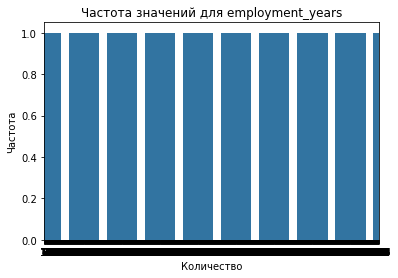

In [74]:
plt.title(f"Частота значений для employment_years")
plt.ylabel('Частота')
plt.xlabel('Количество')
sns.countplot(test_data_features['employment_years']);

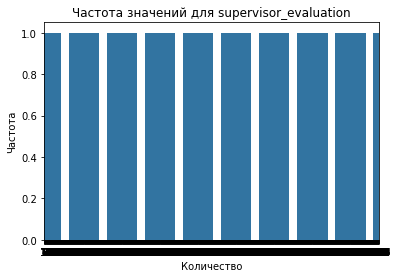

In [75]:
plt.title(f"Частота значений для supervisor_evaluation")
plt.ylabel('Частота')
plt.xlabel('Количество')
sns.countplot(test_data_features['supervisor_evaluation']);

**Вывод**
- Тестовая и тренировочная выборки имеют одинаковое распределение.
- Большая часть работников занимаются продажами, меньшая часть - HR.
- Больше всего работников уровня Junior и меньше всего специалистов уровня Senior.
- По загруженности видно, что примерно у 52% сотрудников средняя занятость, низкая загруженность у 30.2% сотрудников, у 16.85% процентов - высокая.
- Повышение получили всего 2.82 процента сотрудников в течение года.
- Около 14% сотрудников нарушили трудовой договор.
- Процент уволенных сотрудников - около 28.2%.
- Много сотрудников работают около двух лет, более опытных сотрудников меньше и меньше с увеличением значения стажа.
Минимальный стаж сотрудников - 1 год, максимальный - 10 лет.
- Множество сотрудников стараются, потому есть хорошие оценки, но  присутсвуют и недобросовестные сотрудники с оценкой равной 1.
- График распределения зарплаты напоминает распределение Пуасонна, вполне ожидаемо, что хвост будет протягиваться в сторону высоких зарплат.
- Минимальная зарплата - 12000, медиана - 30000, максимальная - 96000.

**Портрет уволившегося сотрудника**

In [76]:
# Отберем строки с уволившимися сотрудниками
quit_data = train_data_quit.query('quit == "yes"')
quit_data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
5,699916,sales,junior,low,1,no,yes,3,18000,yes
9,613206,technology,middle,medium,2,no,no,3,45600,yes
24,468145,technology,junior,medium,2,no,no,3,30000,yes
25,982346,marketing,junior,medium,3,no,no,3,30000,yes


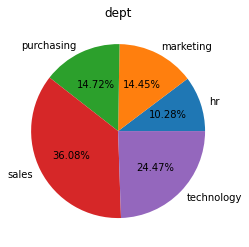

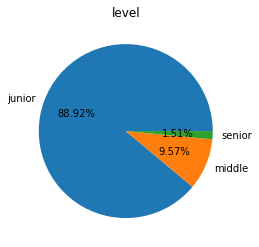

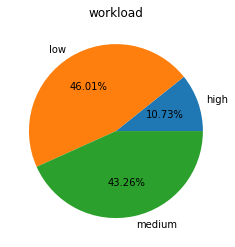

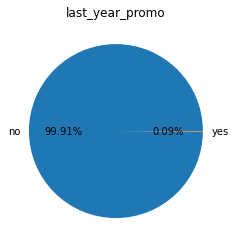

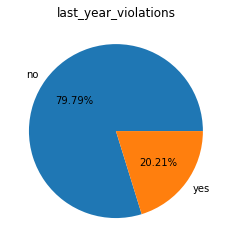

In [77]:
for col in cat_cols:
    if col == 'quit':
        continue
    data_tmp = quit_data.pivot_table(index = col, values = 'id', aggfunc = 'count')
    plt.pie(data_tmp['id'], labels = data_tmp.index, autopct = '%1.2f%%')
    plt.title(col)
    plt.show()

Большая часть уволившихся сотрудников занимались продажами, имели уровень Junior, со средней загруженностью, без нарушений в прошлом году и без повышения.

In [78]:
for col in num_cols:
    if col == 'quit':
        continue
    print(col)
    display(quit_data[col].describe())

employment_years


count    1128.000000
mean        1.844858
std         1.274920
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: employment_years, dtype: float64

supervisor_evaluation


count    1128.000000
mean        3.046099
std         0.973291
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

salary


count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64

In [79]:
train_data_quit.query('quit == "no"')['salary'].describe()

count     2872.000000
mean     37702.228412
std      15218.977339
min      12000.000000
25%      25200.000000
50%      34800.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64

**Проведем анализ дискретных признаков**

In [80]:
train_data_quit.query('quit == "yes"')['employment_years'].describe()

count    1128.000000
mean        1.844858
std         1.274920
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: employment_years, dtype: float64

In [81]:
train_data_quit.query('quit == "yes"')['supervisor_evaluation'].describe()

count    1128.000000
mean        3.046099
std         0.973291
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

In [82]:
train_data_quit.query('quit == "no"')['employment_years'].describe()

count    2872.000000
mean        4.430710
std         2.544635
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

In [83]:
train_data_quit.query('quit == "no"')['supervisor_evaluation'].describe()

count    2872.000000
mean        3.643106
std         0.965295
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

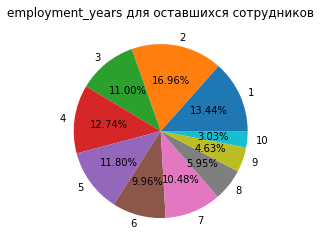

In [84]:
plt.title(f"Частота значений для employment_years для оставшихся сотрудников")
data_tmp = train_data_quit.query('quit == "no"').pivot_table(index = "employment_years", values = 'id', aggfunc = 'count')
plt.pie(data_tmp['id'], labels = data_tmp.index, autopct = '%1.2f%%')
plt.title("employment_years для оставшихся сотрудников")
plt.show()

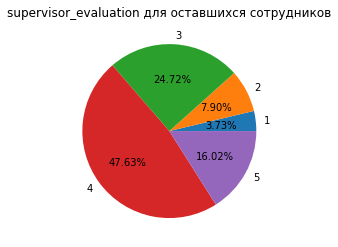

In [85]:
plt.title(f"Частота значений для supervisor_evaluation для оставшихся сотрудников")
data_tmp = train_data_quit.query('quit == "no"').pivot_table(index = "supervisor_evaluation", values = 'id', aggfunc = 'count')
plt.pie(data_tmp['id'], labels = data_tmp.index, autopct = '%1.2f%%')
plt.title("supervisor_evaluation для оставшихся сотрудников")
plt.show()

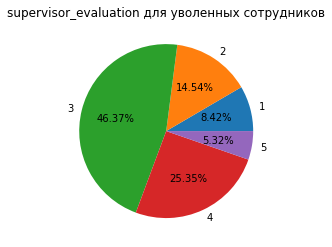

In [86]:
plt.title(f"Частота значений для supervisor_evaluation для уволенных сотрудников")
data_tmp = train_data_quit.query('quit == "yes"').pivot_table(index = "supervisor_evaluation", values = 'id', aggfunc = 'count')
plt.pie(data_tmp['id'], labels = data_tmp.index, autopct = '%1.2f%%')
plt.title("supervisor_evaluation для уволенных сотрудников")
plt.show()

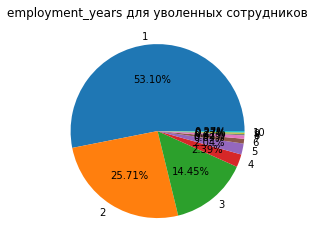

In [87]:
plt.title(f"Частота значений для employment_years для уволенных сотрудников")
data_tmp = train_data_quit.query('quit == "yes"').pivot_table(index = "employment_years", values = 'id', aggfunc = 'count')
plt.pie(data_tmp['id'], labels = data_tmp.index, autopct = '%1.2f%%', radius=1)
plt.title("employment_years для уволенных сотрудников")
plt.show()

В среднем уволенные сотрудники работали минимум 1 год, максимум - 10 лет.
Медиана оценки руководителя = 3.
Медиана зарплаты уволенного сотрудника - 22800. У оставшегося сотрудника - 34800. Это объясняет, почему сотрудники уровня Junior уходят чаще. 
Можно также отметить, что параметр supervisor_evaluation для уволенных сотрудников в основном 3. Это не очень хороший показатель, может это и была одна из причин для увольнения. employment_years для уволенных сотрудников - в основном год. То есть работники уходили в первые два года работы. Либо из-за того, что понимали, что выбрали не то направление для работы, либо плохо старались (основываюсь на показателе supervisor_evaluation).

**Вывод**

- Уволившихся в прошлом году сотрудников - 28.2%. Это достаточно много.
- Много сотрудников работают около 2.5 лет, с увеличением значения стажа опытных сотрудников меньше и меньше.
- Множество сотрудников стараются, потому медиана составляет 4, но и присутсвуют недобросовестные сотрудники с оценкой равной 1.
- График распределения зарплаты напоминает распределение Пуасонна. Хвост протягивается в сторону высоких зарплат с медианой около начала координат.

**Корреляционный анализ**

In [88]:
test_data_quit_2 = test_data_target.merge(test_data_target_quit, on='id')
test_data_quit_yes = test_data_quit_2[test_data_quit_2['quit'] == 'yes']
test_data_quit_no = test_data_quit_2[test_data_quit_2['quit'] == 'no']

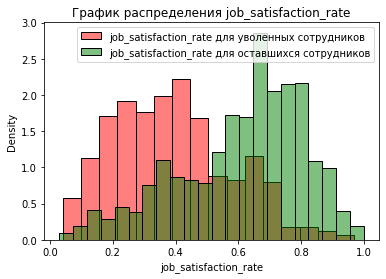

In [89]:
#job_satisfaction_rate
sns.histplot(data=test_data_quit_yes['job_satisfaction_rate'], stat='density', common_norm=False, alpha=0.5, color='r');
sns.histplot(data=test_data_quit_no['job_satisfaction_rate'], stat='density', common_norm=False, alpha=0.5, color='g');
plt.title(f"График распределения job_satisfaction_rate");
plt.legend(['job_satisfaction_rate для уволенных сотрудников', 'job_satisfaction_rate для оставшихся сотрудников']);

**Можно заметить, что оценка "job_satisfaction_rate" уволенных сотрудников в основном находится в диапазоне от 0 до 0.5,
а, что касается оставшихся - в основном в диапазоне от 0.6 до 0.9. Можно сделать вывод, что уровень удовлетворенности сотрудника влияет на то, уволится ли сотрудник.**

Предсказанный признак *job_satisfaction_rate* может коррелировать с таргет признаком, потому необходимо добавить этот признак в train_data и test_data.

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.581833
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.829121
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.319895
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.255698
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.725670
...,...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no,0.557168
3996,672059,sales,middle,high,9,no,no,4,52800,no,0.770035
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes,0.462121
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no,0.508063


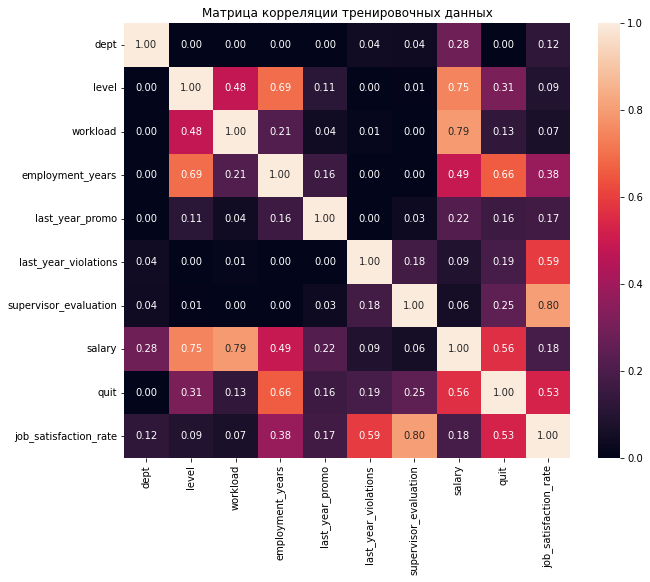

In [90]:
y_pred_df = pd.DataFrame(data = y_predict, columns=['job_satisfaction_rate'])
test_data_quit = test_data_features.merge(y_pred_df, left_index=True, right_index=True).merge(test_data_target_quit, on='id')
X_quit_encoded = best_model_preprocessor.transform(train_data_quit)
train_data_quit['job_satisfaction_rate'] = best_model.predict(X_quit_encoded)
display(train_data_quit)
interval_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
fig, axes = plt.subplots(figsize=(10, 8))
sns.heatmap(train_data_quit.drop(['id'], axis=1).phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f', ax=axes)

plt.title('Матрица корреляции тренировочных данных')
plt.show()

In [91]:
test_data_quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.786847,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.693584,no
2,467458,sales,middle,low,5,no,no,4,19200,0.620520,no
3,418655,sales,middle,low,6,no,no,4,19200,0.662891,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.699662,no
...,...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.556638,yes
1996,109582,technology,middle,low,3,no,no,2,21600,0.159750,yes
1997,305653,technology,junior,low,1,no,no,3,14400,0.224268,yes
1998,160233,technology,middle,low,8,no,no,1,32400,0.540669,no


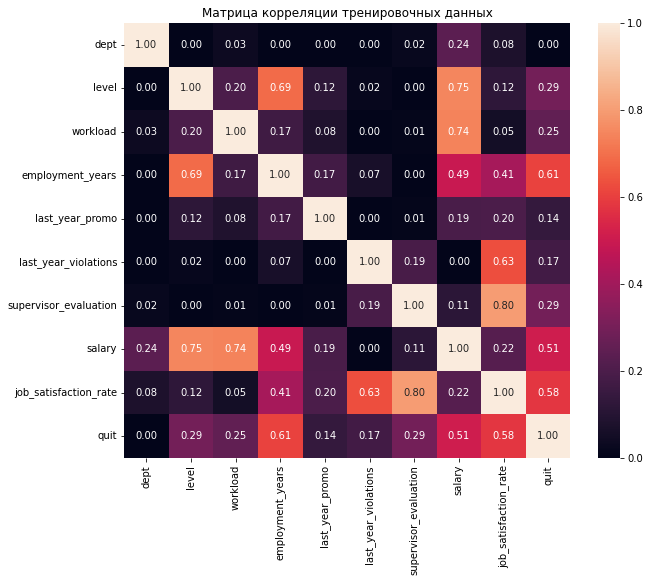

In [92]:
fig, axes = plt.subplots(figsize=(10, 8))
sns.heatmap(test_data_quit.drop(['id'], axis=1).phik_matrix(interval_cols = interval_cols), annot=True, fmt='.2f', ax=axes)

plt.title('Матрица корреляции тренировочных данных')
plt.show()

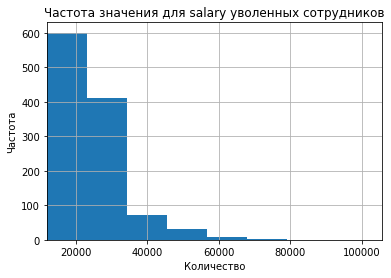

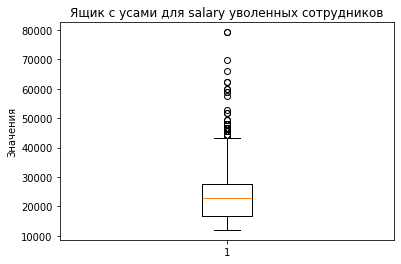



Статистика уволенных сотрудников


count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64

In [93]:
train_data_quit.query('quit == "yes"')[col].hist(bins = math.ceil(np.log(len(train_data_quit[col].unique())) + 1))
plt.xlim(train_data_quit.query('quit == "yes"')[col].min(), train_data_quit[col].max() * 1.1)
plt.title(f"Частота значения для {col} уволенных сотрудников")
plt.ylabel('Частота')
plt.xlabel('Количество')
plt.show()
plt.boxplot(train_data_quit.query('quit == "yes"')[col])
plt.title(f"Ящик с усами для {col} уволенных сотрудников")
plt.ylabel('Значения')
plt.show()
print("\n")
print("Статистика уволенных сотрудников")
display(train_data_quit.query('quit == "yes"')[col].describe())
print("\n")
print("\n")

**Распределение оценки удовлетворенности уволенных и оставшихся сотрудников**

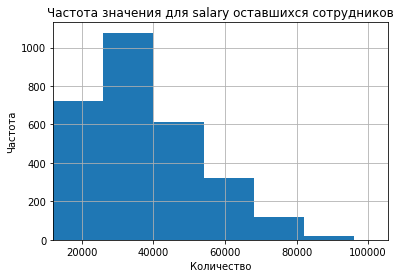

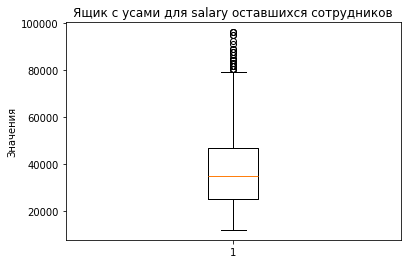



Статистика оставшихся сотрудников


count     2872.000000
mean     37702.228412
std      15218.977339
min      12000.000000
25%      25200.000000
50%      34800.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64

In [94]:
train_data_quit.query('quit == "no"')[col].hist(bins = math.ceil(np.log(len(train_data_quit[col].unique())) + 1))
plt.xlim(train_data_quit.query('quit == "no"')[col].min(), train_data_quit[col].max() * 1.1)
plt.title(f"Частота значения для {col} оставшихся сотрудников")
plt.ylabel('Частота')
plt.xlabel('Количество')
plt.show()
print("\n")
plt.boxplot(train_data_quit.query('quit == "no"')[col])
plt.title(f"Ящик с усами для {col} оставшихся сотрудников")
plt.ylabel('Значения')
plt.show()
print("\n")
print("Статистика оставшихся сотрудников")
display(train_data_quit.query('quit == "no"')[col].describe())
print("\n")

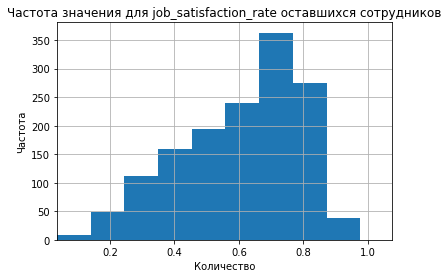

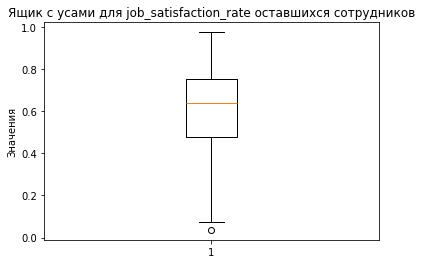



Статистика оставшихся сотрудников


count    1436.000000
mean        0.607185
std         0.185942
min         0.036143
25%         0.476490
50%         0.640417
75%         0.756042
max         0.976165
Name: job_satisfaction_rate, dtype: float64

In [95]:
test_data_quit.query('quit == "no"')['job_satisfaction_rate'].hist(bins = math.ceil(np.log(len(test_data_quit['job_satisfaction_rate'].unique())) + 1))
plt.xlim(test_data_quit.query('quit == "no"')['job_satisfaction_rate'].min(), test_data_quit['job_satisfaction_rate'].max() * 1.1)
plt.title(f"Частота значения для {'job_satisfaction_rate'} оставшихся сотрудников")
plt.ylabel('Частота')
plt.xlabel('Количество')
plt.show()
print("\n")
plt.boxplot(test_data_quit.query('quit == "no"')['job_satisfaction_rate'])
plt.title(f"Ящик с усами для {'job_satisfaction_rate'} оставшихся сотрудников")
plt.ylabel('Значения')
plt.show()
print("\n")
print("Статистика оставшихся сотрудников")
display(test_data_quit.query('quit == "no"')['job_satisfaction_rate'].describe())
print("\n")
print("\n")

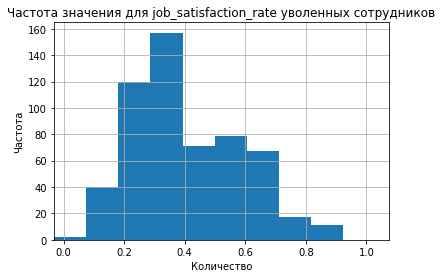

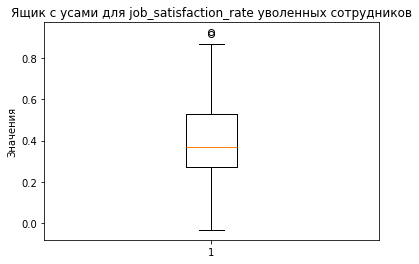



Статистика уволенных сотрудников


count    564.000000
mean       0.402877
std        0.178459
min       -0.032428
25%        0.271654
50%        0.371141
75%        0.528305
max        0.924012
Name: job_satisfaction_rate, dtype: float64

In [96]:
test_data_quit.query('quit == "yes"')['job_satisfaction_rate'].hist(bins = math.ceil(np.log(len(test_data_quit['job_satisfaction_rate'].unique())) + 1))
plt.xlim(test_data_quit.query('quit == "yes"')['job_satisfaction_rate'].min(), test_data_quit['job_satisfaction_rate'].max() * 1.1)
plt.title(f"Частота значения для {'job_satisfaction_rate'} уволенных сотрудников")
plt.ylabel('Частота')
plt.xlabel('Количество')
plt.show()
print("\n")
plt.boxplot(test_data_quit.query('quit == "yes"')['job_satisfaction_rate'])
plt.title(f"Ящик с усами для {'job_satisfaction_rate'} уволенных сотрудников")
plt.ylabel('Значения')
plt.show()
print("\n")
print("Статистика уволенных сотрудников")
display(test_data_quit.query('quit == "yes"')['job_satisfaction_rate'].describe())
print("\n")
print("\n")

Медиана зарплат среди уволенных сотрудников меньше медианы оставшихся, скорее всего это связано с увольнением большого числа уволенных Junior специалистов.

In [97]:
test_data_quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.786847,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.693584,no
2,467458,sales,middle,low,5,no,no,4,19200,0.620520,no
3,418655,sales,middle,low,6,no,no,4,19200,0.662891,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.699662,no
...,...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.556638,yes
1996,109582,technology,middle,low,3,no,no,2,21600,0.159750,yes
1997,305653,technology,junior,low,1,no,no,3,14400,0.224268,yes
1998,160233,technology,middle,low,8,no,no,1,32400,0.540669,no


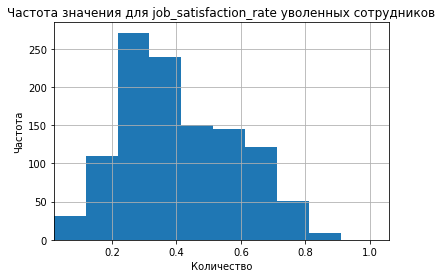

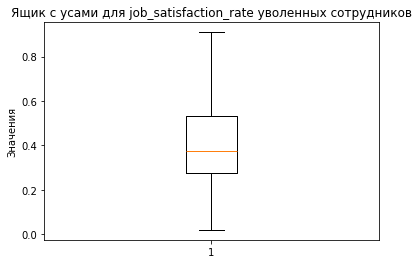



Статистика уволенных сотрудников


count    1128.000000
mean        0.408398
std         0.173959
min         0.019777
25%         0.275470
50%         0.376525
75%         0.534390
max         0.909926
Name: job_satisfaction_rate, dtype: float64

In [98]:
train_data_quit.query('quit == "yes"')['job_satisfaction_rate'].hist(bins = math.ceil(np.log(len(train_data_quit['job_satisfaction_rate'].unique())) + 1))
plt.xlim(train_data_quit.query('quit == "yes"')['job_satisfaction_rate'].min(), train_data_quit['job_satisfaction_rate'].max() * 1.1)
plt.title(f"Частота значения для {'job_satisfaction_rate'} уволенных сотрудников")
plt.ylabel('Частота')
plt.xlabel('Количество')
plt.show()
print("\n")
plt.boxplot(train_data_quit.query('quit == "yes"')['job_satisfaction_rate'])
plt.title(f"Ящик с усами для {'job_satisfaction_rate'} уволенных сотрудников")
plt.ylabel('Значения')
plt.show()
print("\n")
print("Статистика уволенных сотрудников")
display(train_data_quit.query('quit == "yes"')['job_satisfaction_rate'].describe())
print("\n")

Среди уволенных сотрудников обнаружены отрицательные значения job_satisfaction_rate. Это аномалия после прогнозирования.

In [99]:
test_data_quit.query('quit == "yes"')[
    test_data_quit.query('quit == "yes"')['job_satisfaction_rate']< 0.0]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
67,389687,sales,senior,high,2,no,yes,2,63600,-0.032428,yes


In [100]:
test_data_quit['job_satisfaction_rate'] = np.abs(test_data_quit['job_satisfaction_rate'])

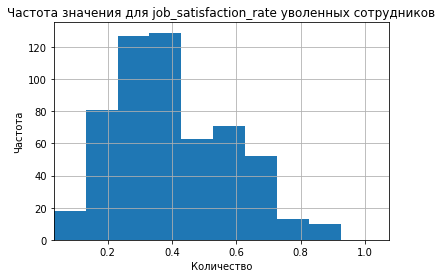

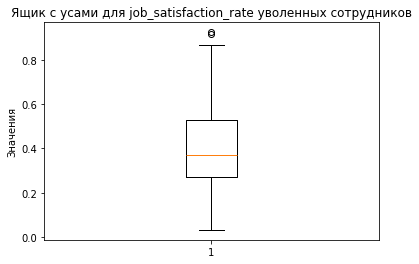



Статистика уволенных сотрудников


count    564.000000
mean       0.402992
std        0.178198
min        0.032428
25%        0.271654
50%        0.371141
75%        0.528305
max        0.924012
Name: job_satisfaction_rate, dtype: float64

In [101]:
test_data_quit.query('quit == "yes"')['job_satisfaction_rate'].hist(bins = math.ceil(np.log(len(test_data_quit['job_satisfaction_rate'].unique())) + 1))
plt.xlim(test_data_quit.query('quit == "yes"')['job_satisfaction_rate'].min(), test_data_quit['job_satisfaction_rate'].max() * 1.1)
plt.title(f"Частота значения для {'job_satisfaction_rate'} уволенных сотрудников")
plt.ylabel('Частота')
plt.xlabel('Количество')
plt.show()
print("\n")
plt.boxplot(test_data_quit.query('quit == "yes"')['job_satisfaction_rate'])
plt.title(f"Ящик с усами для {'job_satisfaction_rate'} уволенных сотрудников")
plt.ylabel('Значения')
plt.show()
print("\n")
print("Статистика уволенных сотрудников")
display(test_data_quit.query('quit == "yes"')['job_satisfaction_rate'].describe())
print("\n")

Убрали отрицательные значения.

Медиана *job_satisfaction_rate* уволенных сотрудников меньше медианы оставшихся, это логично. Уволенный сотрудник скорее всего неудовлетворен работой.

**Вывод**

На показатель ухода больше всего влияет по коэффициенту корреляции - salary, employment_years, job_satisfaction_rate.
Зарплата, опыт работы, удовлетворенность работой - важные факторы в жизни сотрудника.

### Подготовка данных

In [102]:
ohe_cols = ['dept', 'workload', 'last_year_promo', 'last_year_violations']
ord_cols = ['level']
num_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [103]:
pipe_final_class = Pipeline(
    [
        ('preprocessor', data_preprocessing),
        ('models', DecisionTreeClassifier(random_state = RANDOM_STATE))
    ]
)

### Обучение моделей

In [104]:
param_grid_class = [
    {
        'models': [DecisionTreeClassifier(random_state = RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [SVC(random_state = RANDOM_STATE, probability=True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state = RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
] 

Закодируем таргет признаки с помощью LabelEncoder.

In [105]:
l_encoder = LabelEncoder()
y_train_encoded = l_encoder.fit_transform(train_data_quit['quit'])
y_test_encoded = l_encoder.transform(test_data_quit['quit'])
y_test_encoded

array([0, 0, 0, ..., 1, 0, 0])

In [106]:
randomized_search_classifier = RandomizedSearchCV(
    pipe_final_class,
    param_grid_class,
    cv = 5,
    scoring = 'roc_auc',
    random_state = RANDOM_STATE,
    n_jobs = -1
)
randomized_search_classifier.fit(train_data_quit.drop(['id', 'quit'], axis = 1), y_train_encoded)
print('Лучшая модель и её параметры:\n\n', randomized_search_classifier.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search_classifier.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simple_imputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'workload',
                                                   'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[

In [107]:
y_test_pred_proba = randomized_search_classifier.predict_proba(test_data_quit.drop(['id', 'quit'], axis = 1))
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_encoded, y_test_pred_proba[:, 1])}')

Метрика ROC-AUC на тестовой выборке: 0.9271889014006598


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [108]:
# создание и обучение модели DummyClassifier 
dummy_model = DummyClassifier()
dummy_model.fit(train_data_quit.drop(['id', 'quit'], axis = 1), y_train_encoded)

# предсказание на тестовых данных
test_data_encoded = dummy_model.predict(test_data.drop(['id', 'job_satisfaction_rate'], axis = 1))
y_predict_2 = dummy_model.predict(test_data_encoded)

y_test_pred_proba = dummy_model.predict_proba(test_data_quit.drop(['id', 'quit'], axis = 1))
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_encoded, y_test_pred_proba[:, 1])}')

Метрика ROC-AUC на тестовой выборке: 0.5


**Результат модели DecisionTreeClassifier лучше, чем DummyRegressor. Значит найденная модель работает лучше.**

**Вывод**

По итогу работы пайплайна лучшей моделью оказалась DecisionTreeClassifier с max_depth = 5. Метрика на тестовых данных ~0.93, что очень хорошо и удовлетворяет нашим требованиям.

## Общий вывод

- Обучены две модели для задачи регресии и квалификации (SVR, DecisionTreeClassifier).
- В датасетах пропуски есть, но их слишком мало, эти данные можно будет отбросить. Воспользовались пайплайном со стратегией заполнения - most-frequent.
- Большая часть работников занимаются продажами, меньшая часть - HR.
- Больше всего работников уровня Junior и меньше всего специалистов уровня Senior.
- По загруженности видно, что примерно у 52% сотрудников средняя занятость, низкая загруженность у 30% сотрудников, у 18.35% процентов - высокая.
- Повышение получили всего 3 процента сотрудников в течение года.
- Около 14% сотрудников нарушили трудовой договор.
- Много сотрудников работают около двух лет, более опытных сотрудников меньше и меньше с увеличением значения стажа. Минимальный стаж сотрудников - 1 год, максимальный - 10 лет.
- Множество сотрудников стараются, потому есть хорошие оценки, но присутсвуют и недобросовестные сотрудники с оценкой равной 1.
- Минимальная зарплата - 12000, медиана - 30000, максимальная - 98400.
- Гистограмма оценки удовлетворенности сотрудника напоминает нормальное распределение, но с небольшим смещением вправо, что весьма хорошо, это означает, что медиана находится выше чем половина оценки.
- Медиана зарплат среди уволенных сотрудников меньше медианы оставшихся, скорее всего это связано с увольнением большого числа уволенных Junior специалистов.
- Портрет уволенного сотрудника: В среднем уволенные сотрудники работали минимум 1 год, максимум - 10 лет. Медиана оценки руководителя = 3. Медиана зарплаты уволенного сотрудника - 22800.
- Уволившихся в прошлом году сотрудников - 28.2%. Это достаточно много.
- Много сотрудников работают около 2.5 лет, с увеличением значения стажа опытных сотрудников меньше и меньше.
- Множество сотрудников стараются, потому медиана составляет 4, но и присутсвуют недобросовестные сотрудники с оценкой равной 1.
- График распределения зарплаты напоминает распределение Пуасонна. Хвост протягивается в сторону высоких зарплат с медианой около начала координат.

**Рекомендации**

Исходя из результатов исследования, выяснено, что много Junior-специалистов увольняются. Возможно следует ввести дополнительные поощрения для начинающих специалистов.